# Transformers

In this notebook, we will be implementing a simple GPT-style decoder-only Transformer. The implementation is inspired by [nanoGPT](https://github.com/karpathy/nanoGPT/tree/master) for the task of next-token prediction. We will use the tiny Shakespeare dataset, which contains everything William Shakespeare has ever written. The implementation is annotated with useful comments and considerations.  

In [22]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

## Shakespeare dataset

Download the tiny Shakespeare dataset [here](https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt). We can create samples from this text corpus by using a sliding window that scans the entire string with overlapping sequences. Then, we can define the target sequence to be the chosen sequence shifted by one time step. This gives us a way of sampling batches of samples that can be fed to the Transformer model. One preprocessing step at the beginning is transforming individual characters into integer representations. For this, we can maintain two dictionaries: one that encodes characters into integers, and another that converts integers back into characters. 

In [23]:
from torch.utils.data import DataLoader, Dataset

class VocabDataset(Dataset):
    def __init__(self, file_patch: str, seq_len: int):
        f = open(file_patch, 'r')
        corpus = f.read()
        f.close()
        self.seq_len = seq_len
        self.vocab = sorted(list(set(corpus)))
        self.vocab_size = len(self.vocab)
        self.stoi = dict(zip(self.vocab, range(self.vocab_size)))

        self.encoder = lambda c: [self.stoi[ci] for ci in c]
        self.decoder = lambda x: [self.vocab[xi] for xi in x]
        self.data = torch.tensor(self.encoder(corpus))

    def __getitem__(self, index):
        x = self.data[index: index + self.seq_len]
        y = self.data[index+1: index + self.seq_len+1]
        return x, y

    def __len__(self):
        return len(self.data) - self.seq_len

In [24]:
dataset = VocabDataset("../datasets/shakespeare.txt", seq_len=8)

print(f"length of dataset in characters: {len(dataset.data):,}")

# get all the unique characters that occur in this text
print("all the unique characters:", ''.join(dataset.vocab))
print(f"vocab size: {dataset.vocab_size:,}")

length of dataset in characters: 1,115,389
all the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65


In [27]:
loader = DataLoader(dataset, batch_size=4, shuffle=False)

for i, (x, y) in enumerate(loader):

    print(f"batch x shape: {x.shape}\nbatch y shape: {y.shape}")
    for j, (xi, yi) in enumerate(zip(x, y)):
        print(f"batch sample {j}: x=[{''.join(dataset.decoder(xi))}]\t y=[{''.join(dataset.decoder(yi))}]")
        print(f"                x=[{xi}]\t y=[{yi}]")

    if i == 0: break

batch x shape: torch.Size([4, 8])
batch y shape: torch.Size([4, 8])
batch sample 0: x=[First Ci]	 y=[irst Cit]
                x=[tensor([18, 47, 56, 57, 58,  1, 15, 47])]	 y=[tensor([47, 56, 57, 58,  1, 15, 47, 58])]
batch sample 1: x=[irst Cit]	 y=[rst Citi]
                x=[tensor([47, 56, 57, 58,  1, 15, 47, 58])]	 y=[tensor([56, 57, 58,  1, 15, 47, 58, 47])]
batch sample 2: x=[rst Citi]	 y=[st Citiz]
                x=[tensor([56, 57, 58,  1, 15, 47, 58, 47])]	 y=[tensor([57, 58,  1, 15, 47, 58, 47, 64])]
batch sample 3: x=[st Citiz]	 y=[t Citize]
                x=[tensor([57, 58,  1, 15, 47, 58, 47, 64])]	 y=[tensor([58,  1, 15, 47, 58, 47, 64, 43])]


## Transformer modules

For the task of autoregressive prediction, we can use a so-called decoder-only Transformer. The Transformer can be seen as a collection of modules that form a pipeline to transform one sequence of data into another sequence of data. In the image below, the inputs come in from the bottom and are subject to the following transformation steps:
1. **Token embedding** in which the tokens are transformed from integers (representing characters) to learnable vectors 
2. **Positional encoding** in which a positional encoding is added to the embeddings, so that we maintain the order of the sequence
3. **Transformer block** in which we apply several transformations in sequence: 
    - Multi-head Attention mechanism  
    - Position-wise feedforward network
4. **Linear layer** to transform the dimensionality of the sequence back to the output dimensionality
5. **Softmax** to normalize the outputs so that it represents a probability distribution

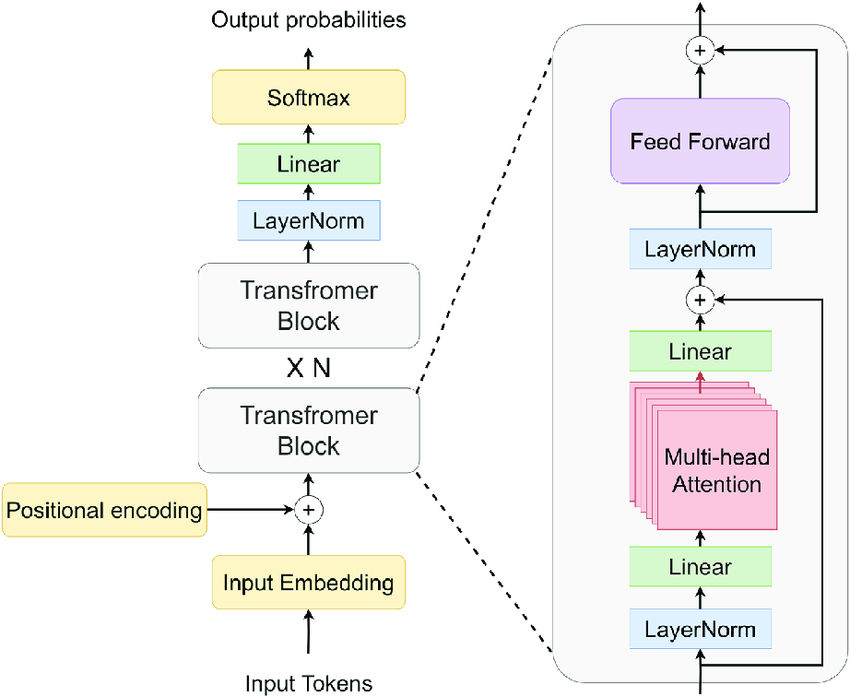

### Embedding and Positional Encoding

The first step is to embed our input sequence. Recall that our sequence of characters is first encoded as a sequence of integers. We then need to embed this integer sequence via linear projection or via a lookup table. Using `nn.Embedding`, a lookup table is created that we can learn via backpropagation. The reason why simply using integers will not suffice is because we often need more than 1 dimension to the represent semantic meaning of tokens, and it is difficult to come up with such an encoding ourselves. Therefore, we instead learn a proper encoding. 

As a side-note, tokens can be regarded as anything in a sequential form. For example, a video consists of a sequence of images, which we can define as tokens. Or a book consists of a sequence of words that we can regard as tokens. In our running example, a string is a sequence of characters that we regard as tokens. 

Once we have embedded our sequence via a learnable lookup table (`nn.Embedding`) or a linear transformation (`nn.Linear`), we need to add positional information to the sequence. The original paper on Transformers called "Attention Is All You Need" (2017) provides a simple positional encoding scheme based on sine and cosine patterns. Alternative options are using a second `nn.Embedding` or `nn.Linear` layer to learn positional encodings. However, often applying a simple scheme does the trick. 

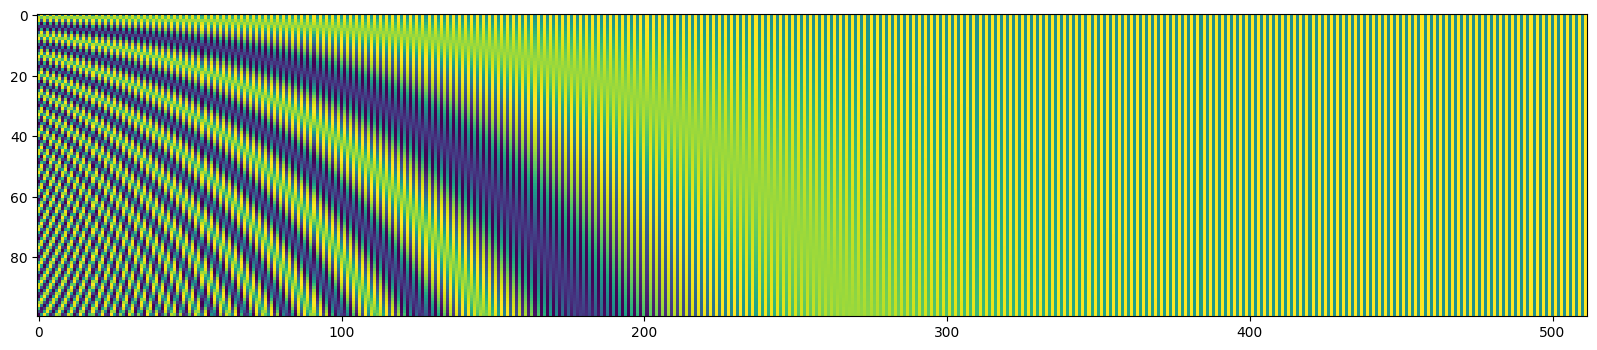

In [28]:
import math

"""
Standard positional encoding layer adopted from "Attention Is All You Need"
"""
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[: x.size(0)]
        return self.dropout(x)
    
enc = PositionalEncoding(d_model=512, max_len=100)
plt.figure(figsize=(20, 5))
plt.imshow(enc.pe.squeeze())

### Attention mechanism

One of the fundamental ideas introduced by the Transformer is the use of the Attention mechanism. The analogy here is taken from the information retrieval literature. Consider a database of information $\mathcal{D}$, we want to search through the database and obtain information. We formulate a query $\mathbf{Q}$, which specifies exactly which information we want to look for in $\mathcal{D}$. Furthermore, the database $\mathcal{D}$ can be decomposed into two components; the keys $\mathbf{K}$ and the values $\mathbf{V}$. Both keys and values are related to each other. We can look for a certain key in $\mathbf{K}$ and then take the values corresponding to this key from $\mathbf{V}$. In Python you could implement this as a dictionary.

In [29]:
# we want to query the value of x
query = "x"

# our database is a simple dictionary of keys and values
database = {
    "x": "Hello, world!",
    "y": "Discussion group lecture of week 8",
    "z": "Minor AI"
}

# obtain value based on query
database[query]

'Hello, world!'

Let's now create a different encoding and try to perform this same query again. We define our dictionary database as two arrays, which we call `keys` and `values`. The `keys` are a one-hot encoding of the keys in the original Python dictionary. Since we had 3 distinct keys ("x", "y", and "z"), we get 3 lists, each containing all zeros except for one distinct value being a one. Naturally, our query will also be a one-hot encoding corresponding to one of the keys. Then, we define the values as a matrix containing 3 rows with each row having an integer encoding of the original strings in the dictionary. This way everything is numerically encoded. 

In [30]:
# one-hot encoding
query = np.array([1, 0, 0])
keys = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])

# label-encoding
max_token = len(max(database.values(), key=lambda x: len(x)))
values = np.array([
    [ord(c) for c in list(val) + ([' '] * (max_token - len(val)))] 
    for val in database.values()
])

query, keys, values

(array([1, 0, 0]),
 array([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]]),
 array([[ 72, 101, 108, 108, 111,  44,  32, 119, 111, 114, 108, 100,  33,
          32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,
          32,  32,  32,  32,  32,  32,  32,  32],
        [ 68, 105, 115,  99, 117, 115, 115, 105, 111, 110,  32, 103, 114,
         111, 117, 112,  32, 108, 101,  99, 116, 117, 114, 101,  32, 111,
         102,  32, 119, 101, 101, 107,  32,  56],
        [ 77, 105, 110, 111, 114,  32,  65,  73,  32,  32,  32,  32,  32,
          32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,
          32,  32,  32,  32,  32,  32,  32,  32]]))

The numerical query operation proceeds as follows:

We take the dot product, i.e., weighted sum, between each key $\mathbf{k}_i \in \mathbf{K}$ and some query $\mathbf{q}$
$$
    \mathbf{k}_i \cdot \mathbf{q} = \sum_{j=1}^d k_{ij}q_j, \qquad \forall \mathbf{k}_i \in \mathbf{K}
$$

This operation can also be seen as a matrix-vector product between all keys $\textbf{K}$ and the query vector $\textbf{q}$:
\begin{align*}
    \textbf{K} \cdot \textbf{q} &= \underbrace{\begin{bmatrix} 
        k_{11} & k_{12} & \dots & k_{1d} \\
        k_{21} & k_{22} & \dots & k_{2d} \\
        \vdots & \vdots & \ddots & \vdots \\
        k_{N1} & k_{N2} & \dots & k_{Nd} \\
    \end{bmatrix} \cdot \begin{bmatrix} q_1 \\ q_2 \\ \vdots \\ q_d \end{bmatrix}}_{\text{matrix-vector product}}\\
\end{align*}

Visualisation: http://matrixmultiplication.xyz/

Often, we normalize the result $\textbf{K} \cdot \textbf{q}$ in every row of the matrix such that the sum of each row equals 1. In other words, we apply a softmax to the rows of the resulting matrix. In this case, it is not needed, because we used a manual encoding.

In the same way, we can apply a matrix-matrix product between $\textbf{K} \cdot \textbf{q}$ and $\textbf{V}$, which means that we retrieve the correct values from the query-key product based on $\textbf{q}$.

In [31]:
out = (keys @ query) @ values
out_str = ''.join([chr(i) for i in out]).strip()
out, out_str

(array([ 72, 101, 108, 108, 111,  44,  32, 119, 111, 114, 108, 100,  33,
         32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,
         32,  32,  32,  32,  32,  32,  32,  32]),
 'Hello, world!')

Of course, this only works for this hand picked example. You can also see this procedure as a *hard* way of querying correct and precise information. Often, however, we do not have precise information when we try to learn a model (due to inevitable noise in the data). The more general formula for attention is the following. 
$$
\text{Attention}(\textbf{Q}, \textbf{K}, \textbf{V}) = \text{softmax}\left(\dfrac{\textbf{Q}\textbf{K}^T}{\sqrt{d}}\right) \textbf{V}
$$

where we apply the same operations as before. Note that $\mathbf{K}^T$ is just $\mathbf{K}$ transposed, i.e., each $\mathbf{K}_{ij}$ become $\mathbf{K}_{ji}$, or we simply switch the rows for the columns. Also notice that we now divide by $\sqrt{d}$, which ensures that the result of $\textbf{Q}\textbf{K}^T$ has unit variance given that both $\textbf{Q}$ and $\textbf{K}^T$ have zero mean and unit variance. 

You might wonder now how this relates to our existing problem and where those $\mathbf{Q}, \mathbf{K}, \mathbf{V}$ matrices came from. Well, this is where **self-attention** and **cross-attention** come into play. In self-attention, we have a given matrix $\mathbf{X}$, which consists of a sequence of data where each time point is a vector of values. We simply apply 3 different linear transformations (i.e., dot products) to $\mathbf{X}$ to obtain $\mathbf{Q}, \mathbf{K}, \mathbf{V}$. 
\begin{align*}
    \mathbf{Q} &= \mathbf{W}_Q \cdot \mathbf{X}\\
    \mathbf{K} &= \mathbf{W}_K \cdot \mathbf{X}\\
    \mathbf{V} &= \mathbf{W}_V \cdot \mathbf{X}\\
\end{align*}
where $\mathbf{W}_Q, \mathbf{W}_K, \mathbf{W}_V$ are the weight matrices of the `nn.Linear` layers. Therefore, in self-attention we attend to $\mathbf{X}$ itself via
$$
\text{Attention}(\mathbf{W}_Q \cdot \mathbf{X}, \mathbf{W}_K \cdot \mathbf{X}, \mathbf{W}_V \cdot \mathbf{X})
$$
Or in other words, given a sequence, attention calculates how important each time point in the sequence is for the task of prediction. We can also regard the attention weights as importance weights that give us some degree of belief that certain elements in the sequence are important, and thus, should be attended to. 

One last topic to consider is that we often mask our attention weights, so that current time points do not attend to future time points. This attention mask should simply be a diagonal matrix with ones in the lower triangular section of the mask and zeros in the upper triangular section of the mask. 

In [32]:
"""
Standard Scaled Dot product attention mechanism
"""
class DotProductAttention(nn.Module):

    def __init__(self, dropout_rate: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.attention_weight = torch.Tensor(0)

    def forward(self, query: torch.Tensor, keys: torch.Tensor, vals: torch.Tensor, mask: torch.Tensor = None):
        # query/keys: (batch_size, n_heads, seq_len, n_hidden/n_heads)
        # vals:       (batch_size, n_heads, seq_len, n_hidden/n_heads)
        d = query.shape[-1]

        # (batch_size, n_heads, seq_len, seq_len)
        presoftmax = query @ keys.transpose(-2, -1) / d ** 0.5
        if mask is not None:
            presoftmax = presoftmax.masked_fill(mask == 0, float('-inf'))

        self.attention_weight = F.softmax(presoftmax, dim=-1)
        self.attention_weight = self.dropout(self.attention_weight)
        # out: (batch_size, n_heads, seq_len, n_hidden/n_heads)
        return self.attention_weight @ vals, self.attention_weight

In [33]:
attn = DotProductAttention()

q = torch.randn(32, 8, 4)
k = torch.randn(32, 8, 4)
v = torch.randn(32, 8, 4)

out, attn_weights = attn(q, k, v)

out.shape, attn_weights.shape

(torch.Size([32, 8, 4]), torch.Size([32, 8, 8]))

### Multi-head attention

In [8]:
"""
Multi-head attention mechanism.
"""
class MultiHeadAttention(nn.Module):

    def __init__(
        self, attention: nn.Module, n_heads: int, n_hidden: int, n_out: int, bias=False
    ):
        super().__init__()
        self.n_heads = n_heads
        self.n_hidden = n_hidden
        self.W_q = nn.LazyLinear(n_hidden, bias=bias)
        self.W_k = nn.LazyLinear(n_hidden, bias=bias)
        self.W_v = nn.LazyLinear(n_hidden, bias=bias)
        self.W_o = nn.LazyLinear(n_out)
        self.attention = attention
        self.attn_weights = torch.Tensor(0)

    def transpose_QKV(self, X: torch.Tensor):
        X = X.reshape(*X.shape[:2], self.n_heads, -1)
        X = X.permute(0, 2, 1, 3)  # (batch_size, n_heads, seq_len, n_hidden/n_heads)
        return X

    def forward(
        self,
        queries: torch.Tensor,
        keys: torch.Tensor,
        values: torch.Tensor,
        mask: torch.Tensor = None,
    ):
        
        K = self.transpose_QKV(self.W_k(keys))
        V = self.transpose_QKV(self.W_v(values))
        Q = self.transpose_QKV(self.W_q(queries))
        # Q, K, V: (batch_size, n_heads, seq_len, n_hidden/n_heads)

        out, self.attn_weights = self.attention(Q, K, V, mask)
        out = out.reshape(
            out.shape[0], out.shape[2], -1
        )  # (batch_size, seq_len, n_hidden*n_heads)

        return self.W_o(out)
    
mha = MultiHeadAttention(DotProductAttention(), 4, 64, 20)

x = torch.randn(32, 8, 20)
mha(x, x, x).shape

torch.Size([32, 8, 20])

### Position-wise feedforward network

In [10]:
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_n_hidden, ffn_n_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_n_hidden)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_n_outputs)
        
    def forward(self, X: torch.Tensor):
        return self.dense2(self.relu(self.dense1(X)))

ffn = PositionWiseFFN(4, 8)
x = torch.randn(32, 3, 4)
ffn(x).shape

torch.Size([32, 3, 8])

### Single Transformer Block

combine layer norm, multi-head attention, position-wise feedforward

Y = Norm(X + f(X))

In [11]:
class TransformerBlock(nn.Module):
    def __init__(
        self,
        n_heads=8,
        n_hidden=64,
        n_out=512,
        ffn_n_hidden=2048,
        _attention=DotProductAttention(),
        dropout=0.1,
        norm_first=True
    ):
        """
        :param n_heads: number of attention heads
        :param n_hidden: dimensionality of each attention head
        :param n_out: dimensionality of output (after multi-head attention and after point-wise feedforward network)
        :param ffn_n_hidden: hidden dimension of feedforward network
        :param _attention: self attention module (default: DotProductAttention)
        :param dropout: dropout rate
        :param norm_first: whether to apply layer normalization before attention layer or after
        """
        super().__init__()
        self.norm_first = norm_first
        self.mha = MultiHeadAttention(_attention, n_heads, n_hidden, n_out)
        self.add_norm1 = AddNorm(n_out, dropout)
        self.ffn = PositionWiseFFN(ffn_n_hidden, n_out)
        self.add_norm2 = AddNorm(n_out, dropout)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm1 = nn.LayerNorm(n_out)
        self.layer_norm2 = nn.LayerNorm(n_out)
        
    def forward(self, X: torch.Tensor, mask: torch.Tensor = None):
        
        if self.norm_first:
            X = self.layer_norm1(X)
            X = X + self.mha(X, X, X, mask)
            X = self.layer_norm2(X)
            X = X + self.ffn(X)
        else:
            X = self.layer_norm1(X + self.mha(X, X, X, mask))
            X = self.layer_norm2(X + self.ffn(X))

        return X

tb = TransformerBlock()
x = torch.randn(32, 8, 512)
tb(x).shape

torch.Size([32, 8, 512])

### Stack of Transformer Blocks

In [12]:
import copy

"""
Autoregressive decoder-only Transformer model. 
Uses naive linear layer for embedding.
"""
class DecoderOnlyTransformer(nn.Module):

    def __init__(
        self,
        vocab_size: int,
        emb_size: int=512,
        n_heads: int=8,
        n_hidden: int=64,
        ffn_n_hidden: int=2048,
        num_layers: int=3,
        _attention: nn.Module=DotProductAttention()
    ):
        """
        :param vocab_size: number of possible input tokens
        :param emb_size: embedding size of d_in (d_model)
        :param n_heads: number of heads in multi-head attention
        :param n_hidden: number of units in Query, Key, Value projection in multi-head attention
        :param ffn_n_hidden: number of hidden units in point-wise FFN
        :param num_layers: number of attention decoder layers
        :param _attention: attention module (default: DotProductAttention)
        """
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_size)
        self.pos_enc = PositionalEncoding(emb_size)

        decoder_block = TransformerBlock(
            n_heads=n_heads,
            n_hidden=n_hidden,
            n_out=emb_size,
            ffn_n_hidden=ffn_n_hidden,
            _attention=_attention
        )
        self.transformer_blocks = nn.ModuleList(
            [copy.deepcopy(decoder_block) for _ in range(num_layers)]
        )
        self.output_layer = nn.LazyLinear(vocab_size)

    def forward(self, X: torch.Tensor, mask: torch.Tensor = None):
        # shape X:  (batch_size, seq_len, 1)
        
        # embedding: (batch_size, seq_len, 1) -> (batch_size, seq_len, emb_size)
        # positional embedding: (seq_len) -> (seq_len, emb_size)
        X = self.pos_enc(self.emb(X))

        # through decoder blocks with same mask shape (seq_len, seq_len)
        for block in self.transformer_blocks:
            X = block(X, mask=mask)

        # output shape: (batch_size, seq_len, vocab_size)
        return self.output_layer(X)

## Test on Shakespeare dataset

In [13]:
# Training constants
EPOCHS = 20
BATCH_SIZE = 512
LEARNING_RATE = 0.001
LEARNING_RATE_GAMMA = 0.9

SEQ_LEN = 32

# Model constants
EMB_SIZE = 64
N_HEADS = 4
N_HIDDEN = EMB_SIZE // N_HEADS
FFN_N_HIDDEN = 4 * EMB_SIZE
NUM_LAYERS = 4

# check for possible GPU usage
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [20]:
dataset = VocabDataset("../datasets/shakespeare.txt", seq_len=SEQ_LEN)

train_indices = list(range(0, int(len(dataset) * 0.8)))
val_indices = list(range(int(len(dataset) * 0.8), int(len(dataset) * 0.9)))
test_indices = list(range(int(len(dataset) * 0.9), len(dataset)))

train_set = torch.utils.data.Subset(dataset, train_indices)
val_set = torch.utils.data.Subset(dataset, val_indices)
test_set = torch.utils.data.Subset(dataset, test_indices)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

mask = torch.tril(torch.ones((SEQ_LEN, SEQ_LEN)), diagonal=0).to(DEVICE)

len(train_loader), len(val_loader), len(test_loader)

(1743, 218, 218)

In [29]:
model = DecoderOnlyTransformer(
    vocab_size=dataset.vocab_size,
    emb_size=EMB_SIZE,
    n_heads=N_HEADS,
    n_hidden=N_HIDDEN,
    ffn_n_hidden=FFN_N_HIDDEN,
    num_layers=NUM_LAYERS
).to(DEVICE)

optim = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=LEARNING_RATE_GAMMA)

train_history = []
val_history = []

for epoch in range(EPOCHS):
    
    batch_losses = []
    for i, (batch_x, batch_y) in enumerate(train_loader):
        
        batch_x, batch_y = batch_x.to(DEVICE), batch_y.to(DEVICE)

        y_pred = model(batch_x, mask)
        y_pred = y_pred.transpose(1, 2)

        loss = F.cross_entropy(y_pred, batch_y)
        batch_losses.append(loss.item())
        
        optim.zero_grad()
        loss.backward()
        optim.step()

    scheduler.step()

    train_history.append(torch.mean(torch.tensor(batch_losses)))

    batch_losses = []
    with torch.no_grad():
        for i, (batch_x, batch_y) in enumerate(val_loader):
            batch_x, batch_y = batch_x.to(DEVICE), batch_y.to(DEVICE)

            y_pred = model(batch_x, mask)
            y_pred = y_pred.transpose(1, 2)
            
            loss = F.cross_entropy(y_pred, batch_y)
            batch_losses.append(loss.item())

    val_history.append(torch.mean(torch.tensor(batch_losses)))
    
    print(f"epoch {epoch}, train_loss {train_history[-1]}, val_loss {val_history[-1]}")


c:\Users\janba\anaconda3\envs\workspace_jan\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


epoch 0, train_loss 1.706408977508545, val_loss 1.1587496995925903
epoch 1, train_loss 0.7618384957313538, val_loss 0.5244892835617065
epoch 2, train_loss 0.44842588901519775, val_loss 0.41576847434043884
epoch 3, train_loss 0.35413122177124023, val_loss 0.3207229971885681
epoch 4, train_loss 0.27267923951148987, val_loss 0.26050451397895813
epoch 5, train_loss 0.23340347409248352, val_loss 0.23008586466312408
epoch 6, train_loss 0.21037890017032623, val_loss 0.19758880138397217
epoch 7, train_loss 0.17440922558307648, val_loss 0.17120862007141113
epoch 8, train_loss 0.1566377878189087, val_loss 0.15531180799007416
epoch 9, train_loss 0.14547251164913177, val_loss 0.14699578285217285
epoch 10, train_loss 0.1382502317428589, val_loss 0.14017353951931
epoch 11, train_loss 0.13273419439792633, val_loss 0.13548968732357025
epoch 12, train_loss 0.12856410443782806, val_loss 0.13094714283943176
epoch 13, train_loss 0.1249811053276062, val_loss 0.12912523746490479
epoch 14, train_loss 0.12229

In [71]:
torch.save(model, '../datasets/shakespeare_model.pkl')

In [15]:
model = torch.load('../datasets/shakespeare_model.pkl', map_location=DEVICE)

/tmp/ipykernel_7143/2901745568.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('../datasets/shakespeare_model.pkl', map_location=DEVICE)


In [16]:
model

DecoderOnlyTransformer(
  (emb): Embedding(65, 64)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): ModuleList(
    (0-3): 4 x TransformerBlock(
      (mha): MultiHeadAttention(
        (W_q): Linear(in_features=64, out_features=16, bias=False)
        (W_k): Linear(in_features=64, out_features=16, bias=False)
        (W_v): Linear(in_features=64, out_features=16, bias=False)
        (W_o): Linear(in_features=16, out_features=64, bias=True)
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (add_norm1): AddNorm(
        (dropout): Dropout(p=0.1, inplace=False)
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (ffn): PositionWiseFFN(
        (dense1): Linear(in_features=64, out_features=256, bias=True)
        (relu): ReLU()
        (dense2): Linear(in_features=256, out_features=64, bias=True)
      )
      (add_norm2): AddNorm

In [21]:
max_new_tokens = 200

# idx = torch.zeros((1, 1), dtype=torch.long, device=DEVICE)
idx, _ = test_set[15]
idx = idx.unsqueeze(0).to(DEVICE)

# idx is (B, T) array of indices in the current context
for _ in range(max_new_tokens):
    # crop idx to the last block_size tokens
    idx_cond = idx[:, -SEQ_LEN:]
    # get the predictions
    logits = model(idx_cond, mask)
    # focus only on the last time step
    logits = logits[:, -1, :] # becomes (B, C)
    # apply softmax to get probabilities
    probs = F.softmax(logits, dim=-1) # (B, C)
    # sample from the distribution
    idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
    # append sampled index to the running sequence
    idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

print(''.join(dataset.decoder(idx.squeeze().tolist())))

who comes here?

GREMIO:
Good mo make torve;
'to will as withre matil I theld, sugh odd, he wesck this, dome.

GLO:
Werths gant he a campiof;
A fat efin olppriou
I muse's. Cand stthaveme yewe the cove stue, ay falnot to Mart tre agi
